In [89]:
# Imports

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVC  
from matplotlib.pyplot import figure
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn import tree

from sklearn import metrics
from sklearn.model_selection import train_test_split

from sktime.classification.shapelet_based import MrSEQLClassifier
from sktime.datasets import load_arrow_head, load_basic_motions

from sktime.datatypes._panel._convert import from_2d_array_to_nested
from sktime.transformations.panel.rocket import Rocket
from sklearn.linear_model import RidgeClassifierCV

from sktime.datasets import load_arrow_head 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.base import clone
import warnings

warnings.filterwarnings('ignore')
pd.set_option("display.max_rows", 100)

In [90]:
# Opening up file containing GWAS data and reading in

file = open("GWAS_Add.raw", "r")
lines = file.readlines()
len(lines)

90

In [91]:
# Loading GWAS data into DF in the correct format

columns = lines[0].strip("\n").split(" ")
columns = [n.split("_", 1)[0] for n in columns]
df = pd.DataFrame(columns=columns)
i = 1
data = []
for line in lines[1:]:
    newRow = line.strip("\n").split(" ")
    for position in range(0, len(newRow)):
        if newRow[position] == "0":
            newRow[position] = "2"
        elif newRow[position] == "2":
            newRow[position] = "0"
        
    data.append(newRow)

df = pd.DataFrame(data, columns=columns)

In [92]:
# Sanity check to see if control SNPs have been encoded correctly

df1 = df[["rs2222162","PHENOTYPE"]]
df1[df1["PHENOTYPE"] == "1"].value_counts()

rs2222162  PHENOTYPE
1          1            22
0          1            17
2          1             6
dtype: int64

In [93]:
# Sanity check to see if cases SNPs have been encoded correctly

df1 = df[["rs2222162","PHENOTYPE"]]
df1[df1["PHENOTYPE"] == "0"].value_counts()

rs2222162  PHENOTYPE
2          0            22
1          0            19
0          0             3
dtype: int64

In [94]:
# Only selecting 100 SNPs located on chromosome 2 

dfAlleles = df.loc[:, "rs11684739":"rs2521953"]
# dfAlleles = df.loc[:, "rs11684739":"rs6757306"] 500
dfInfo = df.loc[:, :"PHENOTYPE"]
df = dfInfo.join(dfAlleles)
len(df.columns)

106

In [95]:
# Fixing Phenotype values

df["PHENOTYPE"] = df["PHENOTYPE"].replace("0","case")
df["PHENOTYPE"] = df["PHENOTYPE"].replace("1","control")

In [96]:
dfSave = df.copy(deep=True)

In [97]:
# Re-encoding SNP of interest to generate stronger signal

#df.loc[df.PHENOTYPE == "case", ["rs2222162"]] = "2"
#df.loc[df.PHENOTYPE == "control", ["rs2222162"]] = "0"

In [98]:
# Testing to see if amplifying singal increases accuracy

# df.insert(df.columns.get_loc("rs2222162"), "rs222216_1", df["rs2222162"])
# df.insert(df.columns.get_loc("rs2222162"), "rs222216_2", df["rs2222162"])
# df.insert(df.columns.get_loc("rs2222162"), "rs222216_3", df["rs2222162"])
# #df.insert(df.columns.get_loc("rs2222162"), "rs222216_4", df["rs2222162"])

In [99]:
# Removing ID columns and 

phenotype = df.pop("PHENOTYPE")
dfTest = df.drop(columns=["FID","IID","PAT","MAT","SEX"])

In [100]:
# Replacing missing SNP entries and replacing with most frequent value for that SNP of other entries

imp = SimpleImputer(missing_values="NA", strategy="most_frequent")
idf = pd.DataFrame(imp.fit_transform(dfTest))
idf.columns = dfTest.columns

In [101]:
# Converting columns to be numberical
idf = idf.apply(pd.to_numeric)

In [102]:
# Getting index of SNP of interest
idfT = idf.T
position = idfT[0].index.get_loc("rs2222162")

('control', 2)

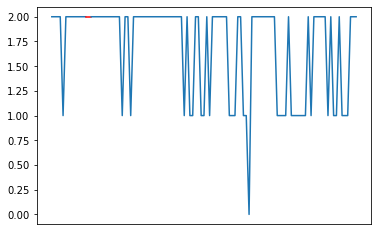

In [169]:
# Visualising entry 0 - control
position = idfT[0].index.get_loc("rs2222162")
plt.xticks([])
plt.plot(idfT[0][0:position-1], color="tab:blue")
plt.plot(idfT[0][position-2:position+1], color="red")
plt.plot(idfT[0][position:],color="tab:blue")
phenotype[position], idfT[0][position]

('control', 1)

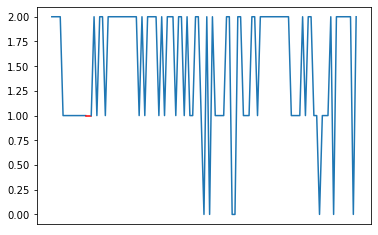

In [171]:
# Visualising entry 1 - control

position = idfT[1].index.get_loc("rs2222162")
plt.xticks([])
plt.plot(idfT[1][0:position-1], color="tab:blue")
plt.plot(idfT[1][position-2:position+1], color="red")
plt.plot(idfT[1][position:],color="tab:blue")
phenotype[position], idfT[1][position]

('control', 2)

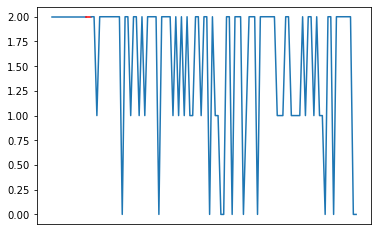

In [172]:
# Visualising entry 2 - case

position = idfT[2].index.get_loc("rs2222162")
plt.xticks([])
plt.plot(idfT[2][0:position-1], color="tab:blue")
plt.plot(idfT[2][position-2:position+1], color="red")
plt.plot(idfT[2][position:],color="tab:blue")
phenotype[position], idfT[2][position]

('control', 2)

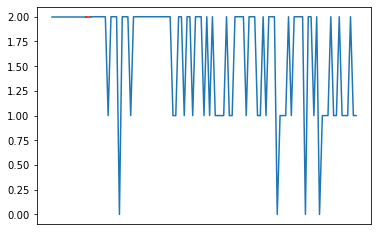

In [173]:
# Visualising entry 10 - case

position = idfT[10].index.get_loc("rs2222162")
plt.xticks([])
plt.plot(idfT[10][0:position-1], color="tab:blue")
plt.plot(idfT[10][position-2:position+1], color="red")
plt.plot(idfT[10][position:],color="tab:blue")
phenotype[position], idfT[10][position]

In [107]:
# Splitting data into training data and testing data

xTrain, xTtest, yTrain, yTest = train_test_split(idf, phenotype, train_size=0.6, random_state=1)

In [108]:
# Finding hyperparameters for RandomForst

# bootstrap = [True, False]
# maxDepth = list(range(10,110,10))
# maxFeatures = ["auto", "sqrt"]
# minSamplesLeaf = [1,2,3,4]
# minSamplesSplit = [2,3,5]
# nEstimators = list(range(100,1100,100))

# hyperparameters = dict(bootstrap=bootstrap, max_depth=maxDepth, max_features=maxFeatures, min_samples_leaf=minSamplesLeaf,
#                       min_samples_split=minSamplesSplit, n_estimators=nEstimators)

# rfd = RandomForestClassifier()

# clf = GridSearchCV(rfd, hyperparameters, cv=10)

# bestModel = clf.fit(idf, phenotype)
# print('Best bootstrap:', bestModel.best_estimator_.get_params()['bootstrap'])
# print('Best max_depth:', bestModel.best_estimator_.get_params()['max_depth'])
# print('Best max_features:', bestModel.best_estimator_.get_params()['max_features'])
# print('Best min_samples_leaf:', bestModel.best_estimator_.get_params()['min_samples_leaf'])
# print('Best min_samples_split:', bestModel.best_estimator_.get_params()['min_samples_split'])
# print('Best n_estimators:', bestModel.best_estimator_.get_params()['n_estimators'])

In [109]:
# Classifying GWAS data using decision tree and printing results

rfc = RandomForestClassifier(bootstrap=True, max_depth=100, max_features="sqrt", 
                             min_samples_leaf=4, min_samples_split=2, n_estimators=100)
rfc.fit(xTrain, yTrain)
yPredicted = rfc.predict(xTrain)
print("Training accuracy score: {}".format(accuracy_score(yTrain, yPredicted)))
yPredicted = rfc.predict(xTtest)
print("Testing accuracy score: {}".format(accuracy_score(yTest, yPredicted)))
print(confusion_matrix(yTest, yPredicted))
print(classification_report(yTest, yPredicted))

Training accuracy score: 0.9433962264150944
Testing accuracy score: 0.5
[[ 6 15]
 [ 3 12]]
              precision    recall  f1-score   support

        case       0.67      0.29      0.40        21
     control       0.44      0.80      0.57        15

    accuracy                           0.50        36
   macro avg       0.56      0.54      0.49        36
weighted avg       0.57      0.50      0.47        36



<BarContainer object of 10 artists>

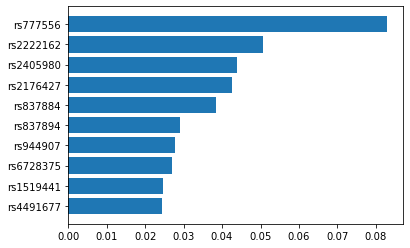

In [110]:
# Plotting features that random forest classifier found important

rf =  pd.DataFrame({"featrue": idf.columns, "importance":rfc.feature_importances_})
sorted_idx = rfc.feature_importances_.argsort()
plt.barh(idf.columns[sorted_idx[-10:]], rfc.feature_importances_[sorted_idx[-10:]])

In [111]:
# Finding hyperparameters for KNN


# leafSize = list(range(1,30))
# neighbours = list(range(1,30))
# p = [1,2]
# hyperparameters = dict(leaf_size=leafSize, n_neighbors=neighbours, p=p)

# knn = KNeighborsClassifier() 

# clf = GridSearchCV(knn, hyperparameters, cv=10)

# bestModel = clf.fit(idf, phenotype)
# print('Best leaf_size:', bestModel.best_estimator_.get_params()['leaf_size'])
# print('Best p:', bestModel.best_estimator_.get_params()['p'])
# print('Best n_neighbors:', bestModel.best_estimator_.get_params()['n_neighbors'])

In [112]:
# Classifying GWAS data using KNN and printing results

knnClf = KNeighborsClassifier(leaf_size=1, n_neighbors=22,p=2 ) 
knnClf.fit(xTrain, yTrain)
yPredicted = knnClf.predict(xTrain)
print("Training accuracy score: {}".format(accuracy_score(yTrain, yPredicted)))
yPredicted = knnClf.predict(xTtest)
print("Testing accuracy score: {}".format(accuracy_score(yTest, yPredicted)))
print(confusion_matrix(yTest, yPredicted))

Training accuracy score: 0.6037735849056604
Testing accuracy score: 0.4722222222222222
[[ 8 13]
 [ 6  9]]


In [113]:
# Finding hyperparameters for KNN

# C = [0.1,1, 10, 100]
# gamma = [1,0.1,0.01,0.001]
# kernel = ['rbf', 'poly', 'sigmoid']
# hyperparameters = dict(C=C,gamma=gamma,kernel=kernel)

# SVM = SVC()

# clf = GridSearchCV(SVM, hyperparameters, refit=True,cv=10)

# bestModel = clf.fit(idf, phenotype)
# print('Best C:', bestModel.best_estimator_.get_params()['C'])
# print('Best gamma:', bestModel.best_estimator_.get_params()['gamma'])
# print('Best kernel:', bestModel.best_estimator_.get_params()['kernel'])

In [114]:
SVM = SVC(kernel="sigmoid", C=100, gamma=0.001)
SVM.fit(xTrain, yTrain)
yPredicted = SVM.predict(xTrain)
print("Training accuracy score: {}".format(accuracy_score(yTrain, yPredicted)))
yPredicted = SVM.predict(xTtest)
print("Testing accuracy score: {}".format(accuracy_score(yTest, yPredicted)))
print(confusion_matrix(yTest, yPredicted))

Training accuracy score: 0.9245283018867925
Testing accuracy score: 0.4166666666666667
[[ 6 15]
 [ 6  9]]


In [115]:
# Converting df columns into 2d numpy array time series

idf = idf.apply(pd.to_numeric)
idfSeries = from_2d_array_to_nested(idf)

In [116]:
# Splitting time seriesdata into training data and testing data

xTrain, xTest, yTrain, yTest = train_test_split(idfSeries, phenotype, train_size=0.6, random_state=1)

In [117]:
# Extracting values from training split

yTrain = yTrain.values
yTest = yTest.values

xTrain = xTrain.reset_index()
xTrain = xTrain.drop(columns=["index"])

xTest = xTest.reset_index()
xTest = xTest.drop(columns=["index"])

In [118]:
# Running rocket kernal transformation on training data

rocket = Rocket()
rocket.fit(xTrain)
xTrainTransform = rocket.transform(xTrain)

In [119]:
# Classifying GWAS Data from rocket transformation using Ridge Classifier

classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)
classifier.fit(xTrainTransform, yTrain)
xTestTransform = rocket.transform(xTest)
yPredict = classifier.predict(xTestTransform)
print("Accuracy with Rocket: %2.3f" % metrics.accuracy_score(yTest, yPredict))
print(confusion_matrix(yTest, yPredict))
print(classification_report(yTest, yPredict))

Accuracy with Rocket: 0.583
[[ 9 12]
 [ 3 12]]
              precision    recall  f1-score   support

        case       0.75      0.43      0.55        21
     control       0.50      0.80      0.62        15

    accuracy                           0.58        36
   macro avg       0.62      0.61      0.58        36
weighted avg       0.65      0.58      0.57        36



In [120]:
# Classifying GWAS data using MrSEQL

ms = MrSEQLClassifier(seql_mode="clf")
ms.fit(xTrain, yTrain)
yPredict = ms.predict(xTest)
print("Accuracy with MrSEQL: %2.3f" % metrics.accuracy_score(yTest, yPredict))
print(confusion_matrix(yTest, yPredict))
print(classification_report(yTest, yPredict))

Accuracy with MrSEQL: 0.667
[[12  9]
 [ 3 12]]
              precision    recall  f1-score   support

        case       0.80      0.57      0.67        21
     control       0.57      0.80      0.67        15

    accuracy                           0.67        36
   macro avg       0.69      0.69      0.67        36
weighted avg       0.70      0.67      0.67        36



In [121]:
# Method to setup df for testing

def SetupTest(df):
    imp = SimpleImputer(missing_values="NA", strategy="most_frequent")
    idf = pd.DataFrame(imp.fit_transform(df))
    idf.columns = df.columns
    idf = idf.apply(pd.to_numeric)
    return idf

In [122]:
# Method to generate graph that displays change in accuracy for a given classifier as the length of the target SNP
#    is increasde

def GenerateSignalGraph(df, classifier):
    
    results = []
    dfTest = df.copy(deep=True)
    phenotype = dfTest.pop("PHENOTYPE")
    dfTest = dfTest.drop(columns=["FID","IID","PAT","MAT","SEX"])
    for n in range(1,10):
        classifierTemp = clone(classifier)
        dfTest.insert(dfTest.columns.get_loc("rs2222162"), f"rs222216_{n}", dfTest["rs2222162"])
        idf = SetupTest(dfTest)
        xTrain, xTest, yTrain, yTest = train_test_split(idf, phenotype, train_size=0.6, random_state=1)
        classifierTemp.fit(xTrain, yTrain)
        yPredict = classifierTemp.predict(xTest)
        results.append(metrics.accuracy_score(yTest, yPredict))
        
        if n == 9:
            print(f"Accuracy with 10 length signal: {metrics.accuracy_score(yTest, yPredict)}")
            print(confusion_matrix(yTest, yPredict))
            print(classification_report(yTest, yPredict))
            
    plt.plot(results)

Accuracy with 10 length signal: 0.6944444444444444
[[13  8]
 [ 3 12]]
              precision    recall  f1-score   support

        case       0.81      0.62      0.70        21
     control       0.60      0.80      0.69        15

    accuracy                           0.69        36
   macro avg       0.71      0.71      0.69        36
weighted avg       0.72      0.69      0.70        36



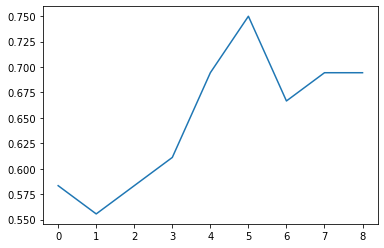

In [123]:
# Plotting change in accuracy for increased signal length for Random Forst

rfc = RandomForestClassifier(bootstrap=True, max_depth=100, max_features="sqrt", 
                             min_samples_leaf=4, min_samples_split=2, n_estimators=100)
GenerateSignalGraph(dfSave, rfc)

Accuracy with 10 length signal: 0.7222222222222222
[[16  5]
 [ 5 10]]
              precision    recall  f1-score   support

        case       0.76      0.76      0.76        21
     control       0.67      0.67      0.67        15

    accuracy                           0.72        36
   macro avg       0.71      0.71      0.71        36
weighted avg       0.72      0.72      0.72        36



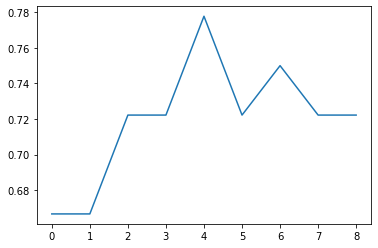

In [124]:
# Plotting change in accuracy for increased signal length for Knn

knnClf = KNeighborsClassifier(leaf_size=1, n_neighbors=22,p=2 ) 
GenerateSignalGraph(dfSave, knnClf)

Accuracy with 10 length signal: 0.6111111111111112
[[12  9]
 [ 5 10]]
              precision    recall  f1-score   support

        case       0.71      0.57      0.63        21
     control       0.53      0.67      0.59        15

    accuracy                           0.61        36
   macro avg       0.62      0.62      0.61        36
weighted avg       0.63      0.61      0.61        36



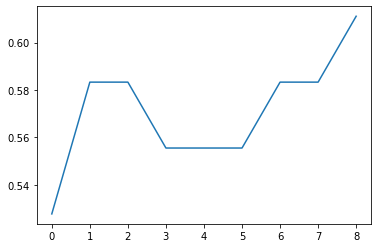

In [125]:
# Plotting change in accuracy for increased signal length for SVM

SVM = SVC(kernel="sigmoid", C=100, gamma=0.001)
GenerateSignalGraph(dfSave, SVM)

Accuracy with 10 length signal: 0.6666666666666666
[[12  9]
 [ 3 12]]
              precision    recall  f1-score   support

        case       0.80      0.57      0.67        21
     control       0.57      0.80      0.67        15

    accuracy                           0.67        36
   macro avg       0.69      0.69      0.67        36
weighted avg       0.70      0.67      0.67        36



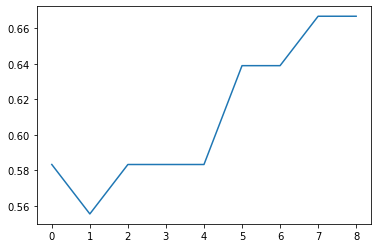

In [126]:
results = []
dfTest = dfSave.copy(deep=True)
phenotype = dfTest.pop("PHENOTYPE")
dfTest = dfTest.drop(columns=["FID","IID","PAT","MAT","SEX"])

for n in range(1,10):
    
    dfTest.insert(dfTest.columns.get_loc("rs2222162"), f"rs222216_{n}", dfTest["rs2222162"])
    idf = SetupTest(dfTest)
    idfSeries = from_2d_array_to_nested(idf)
    
    xTrain, xTest, yTrain, yTest = train_test_split(idfSeries, phenotype, train_size=0.6, random_state=1)
    
    yTrain = yTrain.values
    yTest = yTest.values

    xTrain = xTrain.reset_index()
    xTrain = xTrain.drop(columns=["index"])

    xTest = xTest.reset_index()
    xTest = xTest.drop(columns=["index"])
    
    rocket = Rocket()
    rocket.fit(xTrain)
    xTrainTransform = rocket.transform(xTrain)
    
    classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)
    classifier.fit(xTrainTransform, yTrain)
    xTestTransform = rocket.transform(xTest)
    yPredict = classifier.predict(xTestTransform)
    results.append(metrics.accuracy_score(yTest, yPredict))
    
    if n == 9:
        print(f"Accuracy with 10 length signal: {metrics.accuracy_score(yTest, yPredict)}")
        print(confusion_matrix(yTest, yPredict))
        print(classification_report(yTest, yPredict))
    
_ = plt.plot(results)

Accuracy with 10 length signal: 0.8055555555555556
[[15  6]
 [ 1 14]]
              precision    recall  f1-score   support

        case       0.94      0.71      0.81        21
     control       0.70      0.93      0.80        15

    accuracy                           0.81        36
   macro avg       0.82      0.82      0.81        36
weighted avg       0.84      0.81      0.81        36



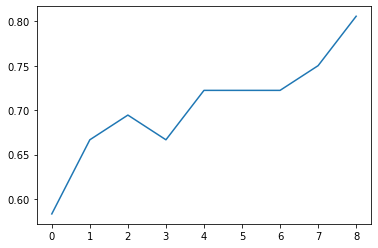

In [165]:
results = []
dfTest = dfSave.copy(deep=True)
phenotype = dfTest.pop("PHENOTYPE")
dfTest = dfTest.drop(columns=["FID","IID","PAT","MAT","SEX"])
idf=None
for n in range(1,10):
    
    dfTest.insert(dfTest.columns.get_loc("rs2222162"), f"rs2222162_{n}", dfTest["rs2222162"])
    idf = SetupTest(dfTest)
    idfSeries = from_2d_array_to_nested(idf)
    
    xTrain, xTest, yTrain, yTest = train_test_split(idfSeries, phenotype, train_size=0.6, random_state=1)
    
    yTrain = yTrain.values
    yTest = yTest.values

    xTrain = xTrain.reset_index()
    xTrain = xTrain.drop(columns=["index"])

    xTest = xTest.reset_index()
    xTest = xTest.drop(columns=["index"])
    
    ms = MrSEQLClassifier(seql_mode="clf")
    ms.fit(xTrain, yTrain)
    yPredict = ms.predict(xTest)
    results.append(metrics.accuracy_score(yTest, yPredict))
    
    if n == 9:
        print(f"Accuracy with 10 length signal: {metrics.accuracy_score(yTest, yPredict)}")
        print(confusion_matrix(yTest, yPredict))
        print(classification_report(yTest, yPredict))
    
_ = plt.plot(results)

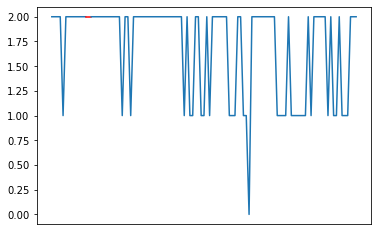

In [166]:
idfT = idf.T
position = idfT[0].index.get_loc("rs2222162")
plt.xticks([])
plt.plot(idfT[0][0:position-1], color="tab:blue")
plt.plot(idfT[0][position-2:position+1], color="red")
plt.plot(idfT[0][position:],color="tab:blue")

In [164]:
idfT[0].to_string()

'rs2222162_9    2\nrs2222162_8    2\nrs2222162_7    2\nrs2222162_6    2\nrs2222162_5    2\nrs2222162_4    2\nrs2222162_3    2\nrs2222162_2    2\nrs2222162_1    2\nrs11684739     2\nrs920438       2\nrs6729313      2\nrs7586936      2\nrs1866657      1\nrs2222162      2\nrs13412133     2\nrs2176427      2\nrs4402698      2\nrs7564109      2\nrs4663058      2\nrs13382758     2\nrs6732056      2\nrs7608937      2\nrs4663087      2\nrs7605172      2\nrs3754609      1\nrs873270       2\nrs1547469      2\nrs905656       1\nrs7568070      2\nrs1604817      2\nrs4150506      2\nrs4150437      2\nrs4233583      2\nrs6737103      2\nrs10173719     2\nrs11691088     2\nrs6753288      2\nrs12151780     2\nrs777569       2\nrs777556       2\nrs2460106      2\nrs10496664     2\nrs6733422      2\nrs777433       2\nrs2288657      2\nrs6753988      2\nrs7575478      1\nrs13393571     2\nrs6756449      1\nrs7608627      1\nrs10188986     2\nrs12104767     2\nrs11692058     1\nrs7570249      1\nrs2438035